In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn=engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#Specify for Honolulu
engine.execute("SELECT max(date) FROM measurement WHERE station in (SELECT station FROM station WHERE name like '%HONOLULU%')").fetchall()
prev_year = dt.date(2015, 10, 30) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
engine.execute("SELECT date, prcp FROM measurement WHERE (date >= '{prev_year}') AND (station in (SELECT station FROM station WHERE name LIKE '%HONOLULU%')) ORDER BY date LIMIT 10").fetchall()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(f"SELECT date, prcp FROM measurement WHERE (date >= '{prev_year}') AND (station in (SELECT station FROM station WHERE name LIKE '%HONOLULU%')) ORDER BY date", conn)
df.set_index('date', inplace=True)

# Sort the dataframe by date
df.head(10)

,prcp
date,
2014-10-30,0.00
2014-10-31,0.00
2014-11-02,0.01
2014-11-03,0.03
2014-11-04,0.00
2014-11-05,0.00
2014-11-06,0.04
2014-11-07,0.03
2014-11-08,0.04


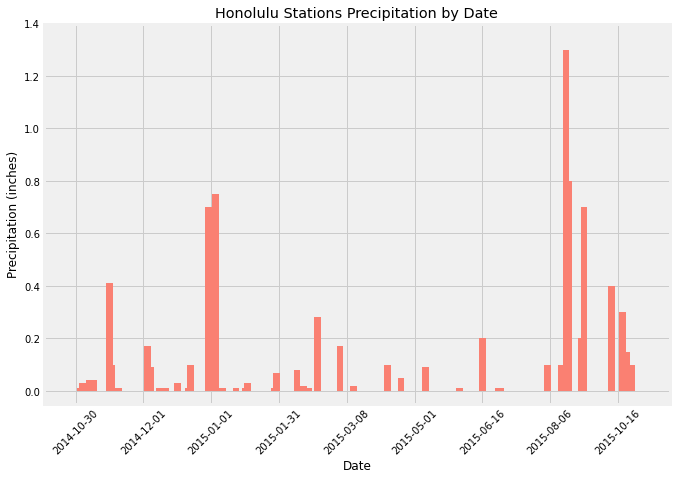

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis=df.index
bars=df.prcp
plt.figure(figsize=(10,7))
plt.bar(x_axis, bars, width=3, color="salmon")
plt.xticks([x for i, x in enumerate(x_axis) if i%30==0], rotation=45)
plt.ylim(-.05, 1.4)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Honolulu Stations Precipitation by Date")
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,212.00000
mean,0.03717
std,0.14334
min,0.00000
25%,0.00000
50%,0.00000
75%,0.00000
max,1.30000


In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = engine.execute("SELECT COUNT(distinct station) FROM measurement").fetchall()[0][0]
print(f"The number of distinct stations is {station_count}")

The number of distinct stations is 9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute("SELECT station, COUNT(prcp) as records_count,(SELECT name FROM station where measurement.station = station.station) AS station_name FROM measurement GROUP BY station_name ORDER BY records_count DESC").fetchall()

[('USC00519281', 2772, 'WAIHEE 837.5, HI US'),
 ('USC00513117', 2696, 'KANEOHE 838.1, HI US'),
 ('USC00519397', 2685, 'WAIKIKI 717.2, HI US'),
 ('USC00519523', 2572, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00516128', 2484, 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00514830', 1937, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00511918', 1932, 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00517948', 683, 'PEARL CITY, HI US'),
 ('USC00518838', 342, 'UPPER WAHIAWA 874.3, HI US')]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_info = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()[0]
print(f"The temp info for station USC00519281 is the following:\nLow: {station_info[0]}\nHigh: {station_info[1]}\nAverage: {round(station_info[2],2)}")

The temp info for station USC00519281 is the following:
Low: 54.0
High: 85.0
Average: 71.66


In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
engine.execute("SELECT station, COUNT(tobs) as records_count, (SELECT name FROM station WHERE measurement.station = station.station) AS station_name FROM measurement GROUP BY station_name ORDER BY records_count DESC").fetchall()

[('USC00519281', 2772, 'WAIHEE 837.5, HI US'),
 ('USC00519397', 2724, 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 2709, 'KANEOHE 838.1, HI US'),
 ('USC00519523', 2669, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00516128', 2612, 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00514830', 2202, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00511918', 1979, 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00517948', 1372, 'PEARL CITY, HI US'),
 ('USC00518838', 511, 'UPPER WAHIAWA 874.3, HI US')]

In [18]:
#figure out what date the dataset will begin at, 1 year from latest data point
engine.execute("SELECT max(date) FROM measurement WHERE station = 'USC00519281'").fetchall()[0][0]
start_date = dt.date(2017,8,18) - dt.timedelta(days=365)
print(f"The temperature observation data will begin at this date: {start_date}.")

The temperature observation data will begin at this date: 2016-08-18.


<Figure size 720x288 with 0 Axes>

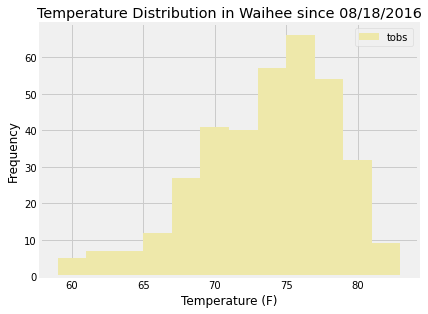

<Figure size 720x288 with 0 Axes>

In [19]:
#Create histogram for station result of previous query
results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= start_date).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12, color="palegoldenrod")
plt.tight_layout()
plt.xlabel("Temperature (F)")
plt.title("Temperature Distribution in Waihee since 08/18/2016")
plt.figure(figsize=(10,4))


## Bonus Challenge Assignment

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?


In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start = dt.date(2016, 12, 1)
end = dt.date(2016, 12, 14)

tmin, tavg, tmax = calc_temps(start.strftime("%Y-%m-%d"),end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

65.0 70.72527472527473 78.0


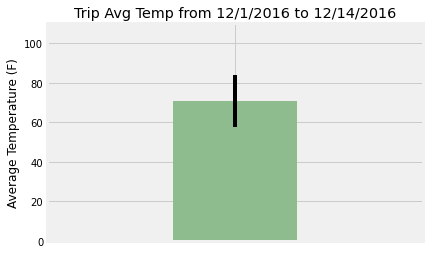

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr=tmax-tmin

plt.bar([""], [tavg], width=.33, color="darkseagreen", yerr=yerr)
plt.ylabel("Average Temperature (F)")
plt.title("Trip Avg Temp from 12/1/2016 to 12/14/2016")
plt.xlim(-.5,.5)
plt.ylim(0,110)
plt.show()

In [23]:
/# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates./
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



SyntaxError: unexpected EOF while parsing (<ipython-input-23-fc81fcf6b595>, line 2)

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
